# AWS Machine Learning Engineer Nanodegree : Project 3 : Image Classification Using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

## References:
- Common Model Architecture Types and Fine-Tuning lesson, finetune_a_cnn_solution.py
- Hyperparameter Tuning in Sagemaker lesson, Exercise: Hyperharameter tuning in Sagemaker
- https://knowledge.udacity.com/questions/880873 - obtaining template for inference.py
- https://knowledge.udacity.com/questions/873847 - using dataset loader, pointing to s3
- https://knowledge.udacity.com/questions/871603 - choosing the right instance type for hyperparameter tuning job: ml.p3.2xlarge
- https://github.com/aws/sagemaker-training-toolkit
- Deploy Deep Learning Models on SageMaker Lesson, SageMaker Debugger section
- AWS Docs - https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/pytorch_mnist/hpo_pytorch_mnist.ipynb
- Udacity nanodegree, Operationalizing Machine Learning on SageMaker section, project, hpo.py

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
#!pip install sagemaker-training
#!pip install torch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import torch

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [3]:
#imports for debugger and profiler
import smdebug.pytorch as smd

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile
)


[2022-11-21 18:46:04.012 ip-172-16-100-35.ec2.internal:7454 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-21 18:46:04.281 ip-172-16-100-35.ec2.internal:7454 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [4]:
role = sagemaker.get_execution_role()

In [5]:
role

'arn:aws:iam::054619787751:role/service-role/AmazonSageMaker-ExecutionRole-20221003T151672'

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [17]:
# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [10]:
#TODO: Fetch and upload the data to AWS S3
#!aws s3 cp --recursive --quiet ./dogImages 's3://sagemaker-us-east-1-054619787751/data/'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": CategoricalParameter([0.001, 0.1]),
    "batch-size": CategoricalParameter([10, 32])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [16]:
#TODO: Create estimators for your HPs

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge"
)

In [17]:
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [10]:
input_data = 's3://sagemaker-us-east-1-260552509205/data'
data_paths = {'training': input_data+'/train/',
              'validation': input_data+'/valid/',
              'testing': input_data+'/test/'}

In [19]:
# TODO: Fit your HP Tuner
tuner.fit(data_paths, wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................!


In [20]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparams = best_estimator.hyperparameters()


2022-11-03 21:25:00 Starting - Found matching resource for reuse
2022-11-03 21:25:00 Downloading - Downloading input data
2022-11-03 21:25:00 Training - Training image download completed. Training in progress.
2022-11-03 21:25:00 Uploading - Uploading generated training model
2022-11-03 21:25:00 Completed - Resource retained for reuse


In [5]:
best_hyperparams

NameError: name 'best_hyperparams' is not defined

In [11]:
best_hyperparams_copy = {'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"10"',
 'learning_rate': '"0.001"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-11-03-21-09-16-647"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-260552509205/pytorch-training-2022-11-03-21-09-16-647/source/sourcedir.tar.gz"'}

In [12]:
best_hyperparams_debug = {
    'batch_size': int(best_hyperparams_copy['batch_size'][1:-1]),
    'learning_rate': float(best_hyperparams_copy['learning_rate'][1:-1])
}

In [13]:
best_hyperparams_debug

{'batch_size': 10, 'learning_rate': 0.001}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.
**References**  - Deploy Deep Learning Models on SageMaker Lesson, SageMaker Debugger section; Operationalizing Machine Learning on SageMaker project

In [15]:
#input_data2 = 's3://sagemaker-ch3-project/'
#data_paths2 = {'training': input_data2+'train/',
#              'validation': input_data2+'valid/',
#              'testing': input_data2+'test/'}
#os.environ['SM_MODEL_DIR']=input_data2+'model/'
#os.environ['SM_OUTPUT_DATA_DIR']=input_data2+'output/'

In [14]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    #debugger rules
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    
    #profiler rules
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1", "eval.save_interval": "1"}
)

#configure profiler
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [46]:
# TODO: Create and fit an estimator
# TODO: Your estimator here

#use best_hyperparams
estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    base_job_name='proj-dog-class',
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1, #1,
    instance_type= "ml.p3.2xlarge", # "ml.m5.xlarge"
    hyperparameters=best_hyperparams_debug,
    profiler_config=profiler_config,
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config
)

In [47]:
estimator.fit({"training": "s3://sagemaker-us-east-1-054619787751/data/"}, wait=False)

### Debugging Output

**TODO**: Plot a debugging output.
**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In this section I will get the training job object and display the training metrics that we were tracking as well as some of the training tensors.

In [49]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [50]:
print(job_name)

proj-dog-class-2022-11-21-20-23-01-547


In [52]:
#get the training job object using the training job name and display the training metrics that we were tracking as well as some of the training tensors.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-11-21 20:48:29.584 ip-172-16-100-35.ec2.internal:7454 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-054619787751/proj-dog-class-2022-11-21-20-23-01-547/debug-output
[2022-11-21 20:48:30.217 ip-172-16-100-35.ec2.internal:7454 WARNING s3handler.py:183] Encountered the exception [SSL: KRB5_S_TKT_NYV] unexpected eof while reading (_ssl.c:2570) while reading s3://sagemaker-us-east-1-054619787751/proj-dog-class-2022-11-21-20-23-01-547/debug-output/index/000000000/000000000053_worker_0.json . Will retry now


In [55]:
#display tensor names
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [56]:
#display tensor lenghts
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

84

In [57]:
#functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


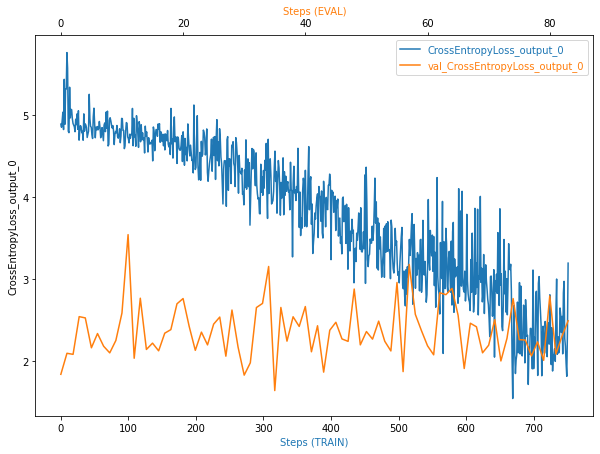

In [58]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

Based on the above plot I do not see anomalous behavior as the cross entropy loss output tensor is steadily decreasing as the training steps increase.
A possible error could be a non-decreasing graph of cross entropy loss as the training steps increased.

### Profiler output


In [ ]:
#TODO: Display the profiler output

In [61]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
profiler_report_name

'ProfilerReport'

In [64]:
import IPython

#IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")
IPython.display.HTML(filename="profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()